# Example time series for introduction

The example time series in the introduction consists of a synthetic ECG signal with three different anomalies.
We chose >3 different anomaly detection algorithms to detect these anomalies.
Every algorithm misses at least one anomaly, but if we consider all algorithms together, we can detect all anomalies.


In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import cycle
from matplotlib.patches import Rectangle
from sklearn.preprocessing import PowerTransformer, MinMaxScaler

from common import generate_intro_example_data, run_algorithms_on

plt.rcParams["figure.figsize"] = (20, 10)

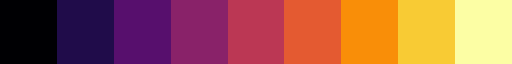

In [2]:
cm = matplotlib.colormaps["inferno"].resampled(9)
cm

array([<AxesSubplot: >, <AxesSubplot: >], dtype=object)

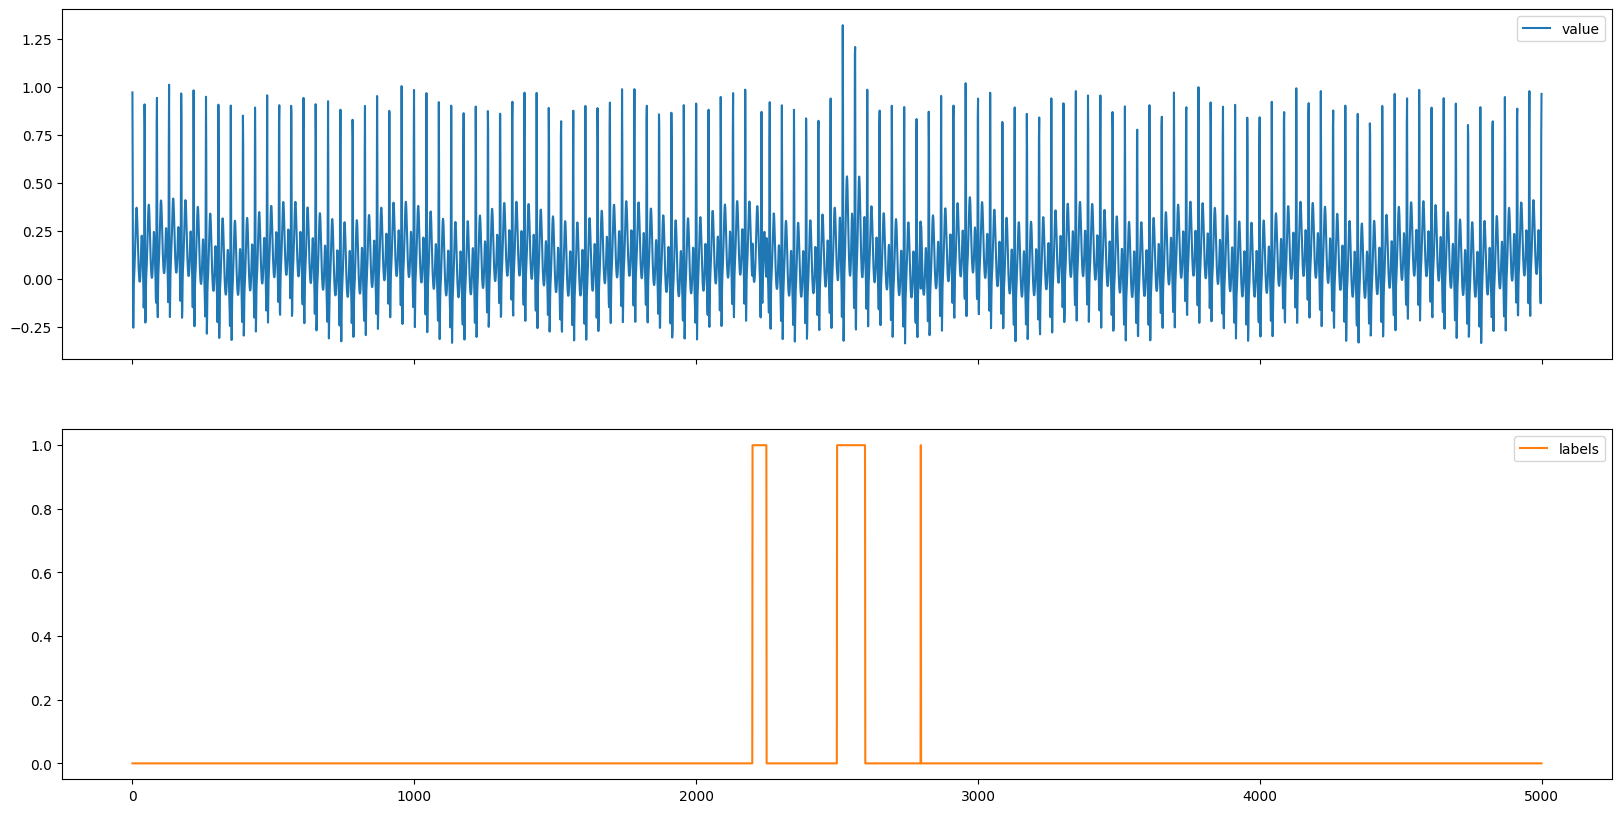

In [3]:
# Create synthetic ECG signal
offset = 2000
df = generate_intro_example_data(anomaly_region_offset=offset)
df[["value", "labels"]].plot(subplots=True)

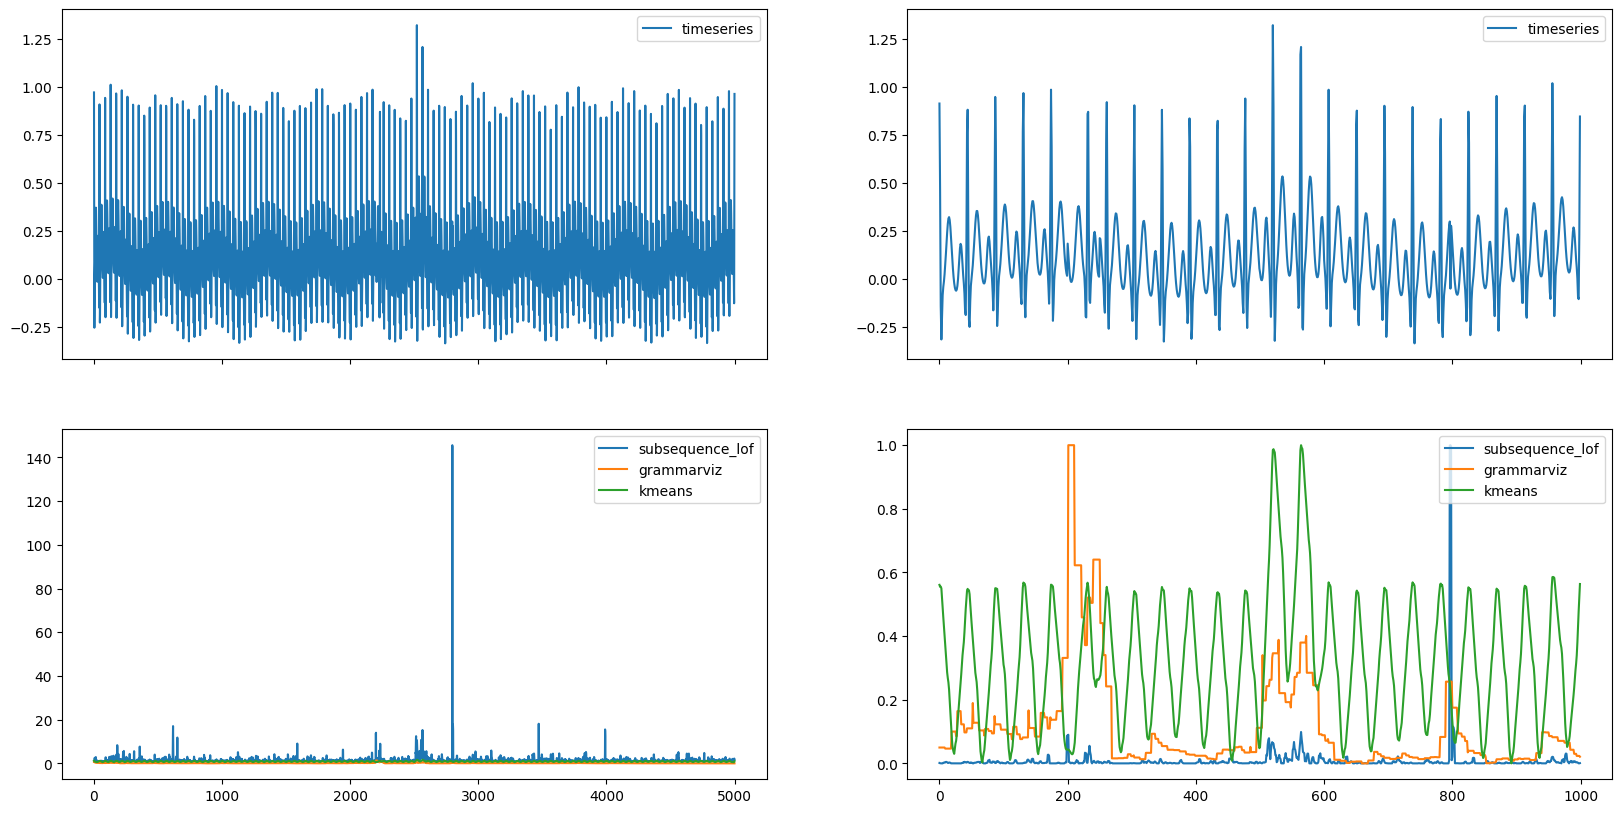

In [4]:
instances = [
    ("subsequence_lof", {"window_size": 3}),
    # ("dwt_mlead", {}),
    ("grammarviz", {}),
    ("kmeans", {"window_size": 20}),
]
df_results = run_algorithms_on(df["value"].values, instances)

fig, axs = plt.subplots(2, 2, sharex="col")
axs[0, 0].plot(df["value"].values, label="timeseries")
axs[0, 0].legend()
for algorithm in df_results.columns:
    axs[1, 0].plot(df_results[algorithm].values, label=algorithm)
axs[1, 0].legend()

axs[0, 1].plot(df.iloc[offset:offset+1000, 1].values, label="timeseries")
axs[0, 1].legend()
for algorithm in df_results.columns:
    s = df_results[algorithm].values[offset:offset+1000]
    s = MinMaxScaler().fit_transform(s.reshape(-1, 1)).reshape(-1)
    axs[1, 1].plot(s, label=algorithm)
axs[1, 1].legend()

plt.show()

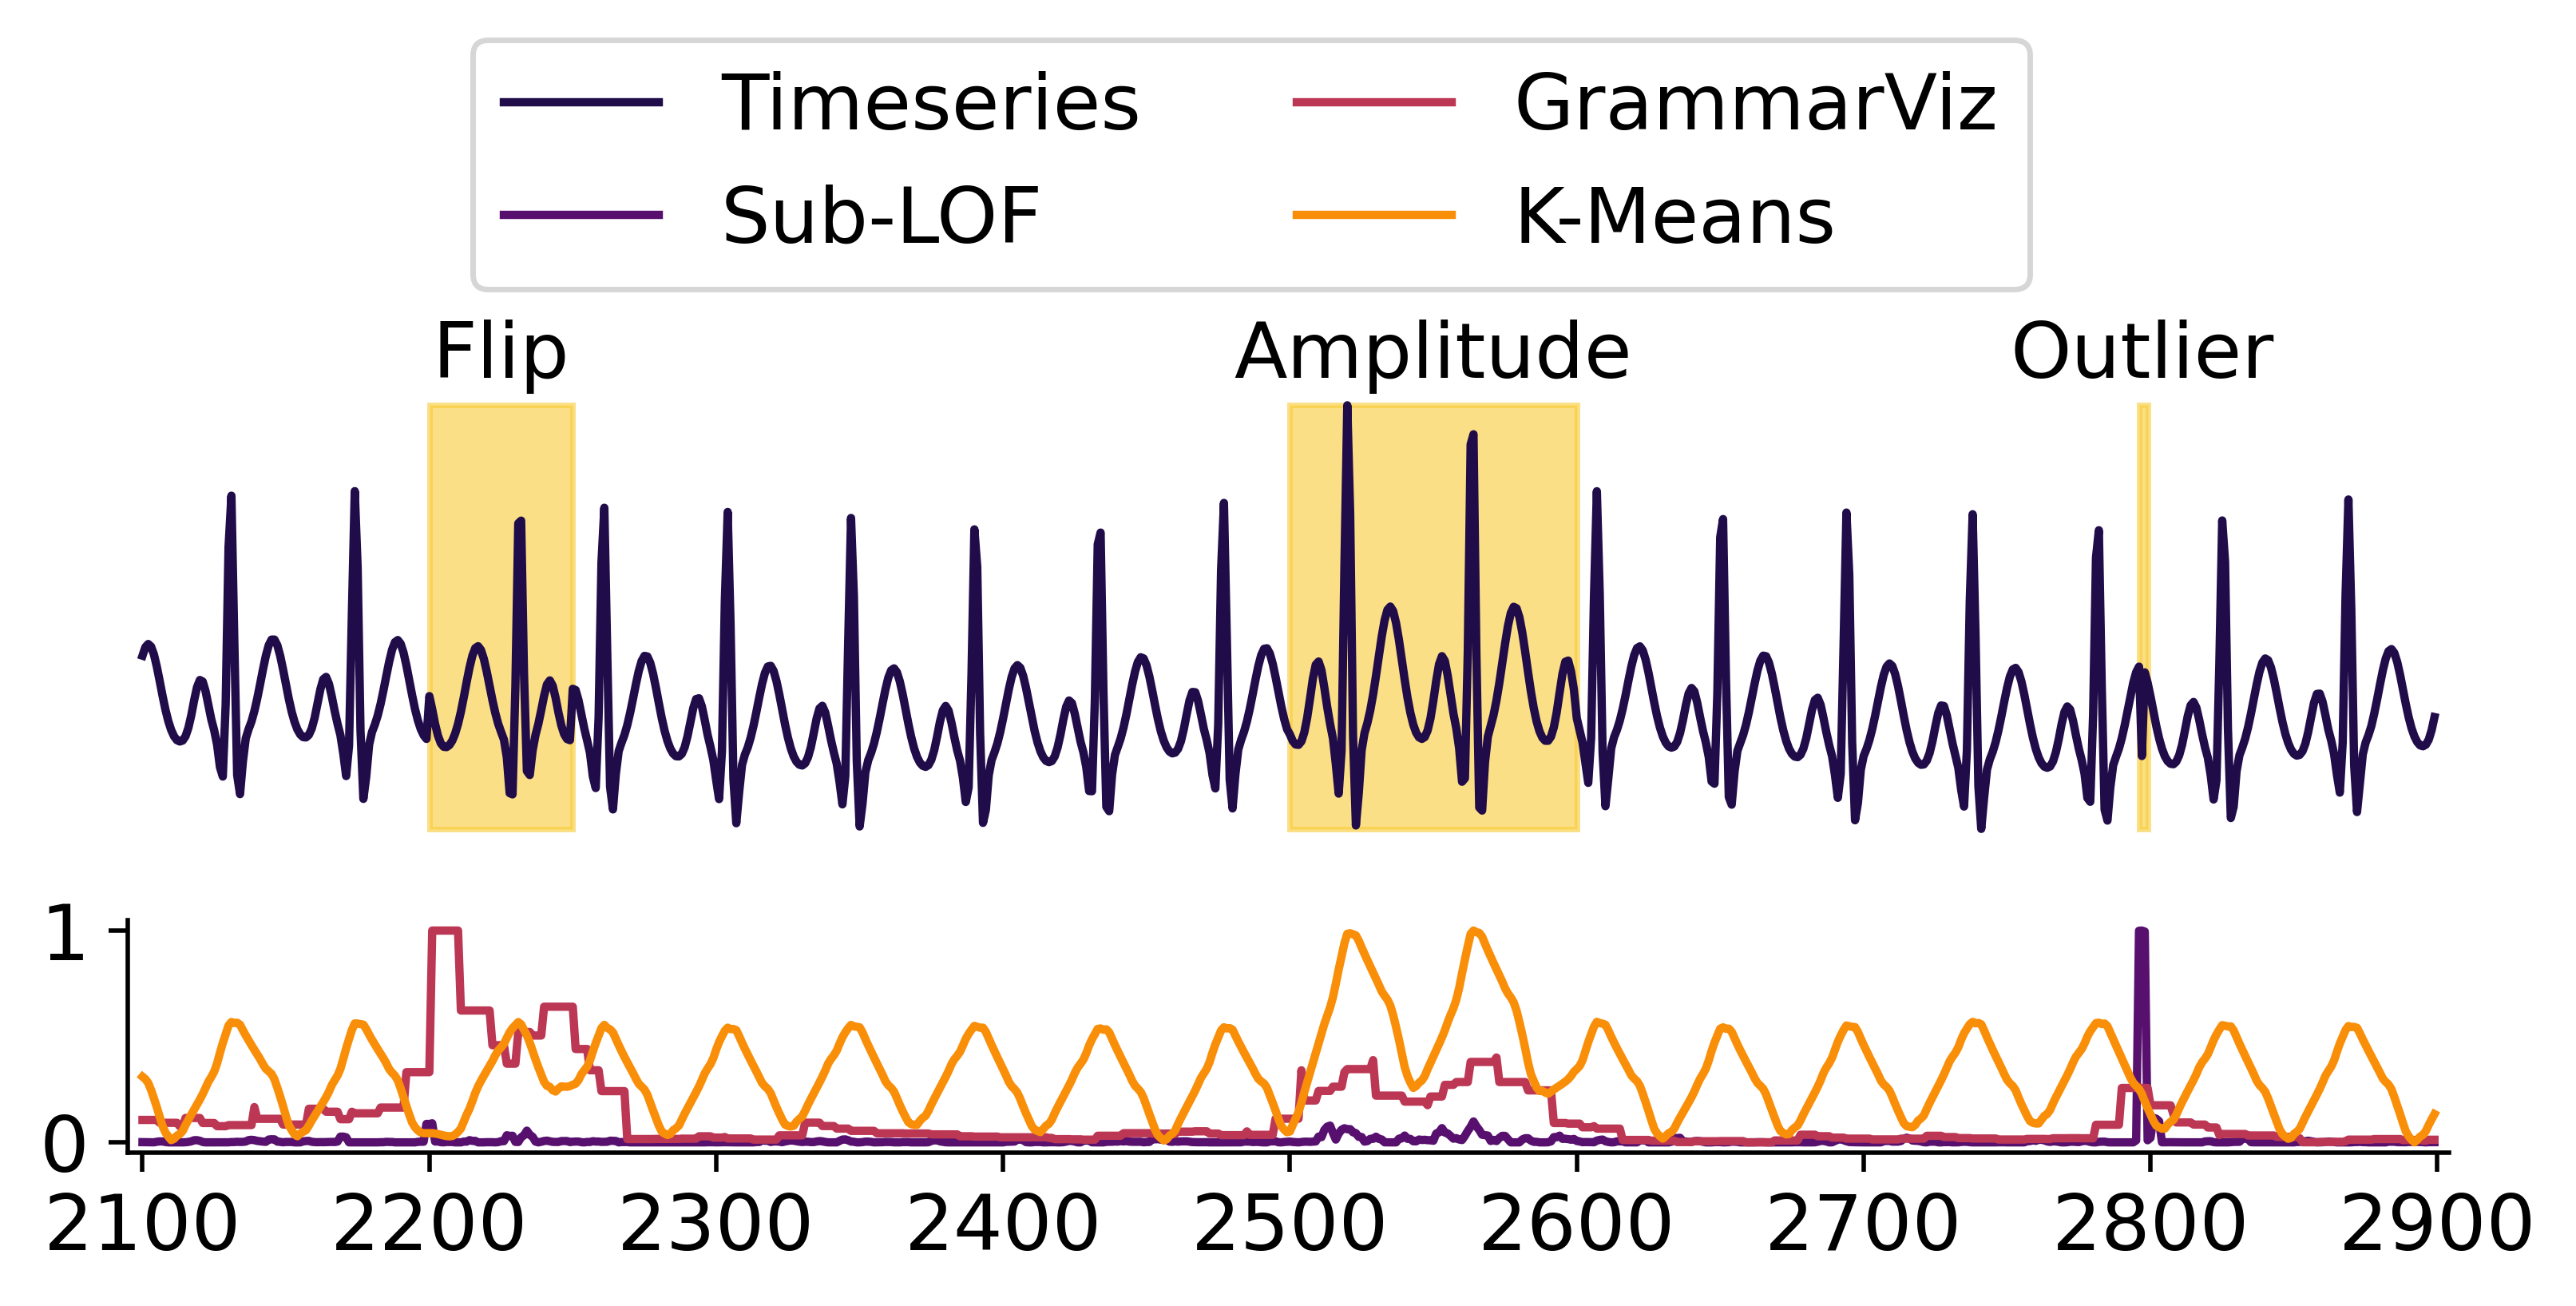

In [5]:
plt.rcParams["font.size"] = 14

show_xticklabels = True
anomaly_highlight_color_alpha = 0.6

# anomaly_highlight_color = "red"
# colors = cycle(["orange", "purple", "brown"])
# ts_color = (0.1, 0.1, .5)

# colors = sns.cubehelix_palette(n_colors=6)[0::2]
# ch_colors = sns.cubehelix_palette(start=.25, rot=-.25, light=0.8, dark=0.2, n_colors=6)
# ts_color = ch_colors[4]
# anomaly_highlight_color = sns.cubehelix_palette()[1]

colors = cm.colors[2:-2][::2]
ts_color = cm.colors[1]
anomaly_highlight_color = cm.colors[-2]

start_idx = offset + 100
end_idx = offset + 900

anomalies = []
labels = df["labels"].diff()
for begin, end in zip(labels[labels == 1].index, labels[labels == -1].index):
    anomalies.append((begin, end))

index = df.index[start_idx:end_idx].values
data = df.iloc[start_idx:end_idx, 1].values
scores = df_results.iloc[start_idx:end_idx, :].values
scores = MinMaxScaler().fit_transform(scores)
algorithms = df_results.columns

fig, axs = plt.subplots(2, 1, sharex="col", figsize=(7.5, 2.5), dpi=500, gridspec_kw={"height_ratios": [2, 1]})

axs[0].plot(index, data, label="Timeseries", color=ts_color)

# mark anomalies
y_min = data.min()
y_max = data.max()
for begin, end in anomalies:
    width = end - begin
    if width < 2:
        width += 2
        begin -= 1
    axs[0].add_patch(Rectangle((begin, y_min), width, y_max-y_min, color=anomaly_highlight_color, alpha=anomaly_highlight_color_alpha))

for algo, score, color in zip(algorithms, scores.T, colors):
    name_mapping = {
        "subsequence_lof": "Sub-LOF",
        "dwt_mlead": "DWT_MLEAD",
        "grammarviz": "GrammarViz",
        "kmeans": "K-Means",
    }
    axs[1].plot(index, score, label=name_mapping[algo], color=color)

# custom annotations
pos = (anomalies[0][0] + (anomalies[0][1] - anomalies[0][0])//2, y_max)
axs[0].annotate("Flip", pos, ha="center", xytext=(0, 5), textcoords="offset points")
pos = (anomalies[1][0] + (anomalies[1][1] - anomalies[1][0])//2, y_max)
axs[0].annotate("Amplitude", pos, ha="center", xytext=(0, 5), textcoords="offset points")
pos = (anomalies[2][0] + (anomalies[2][1] - anomalies[2][0])//2, y_max)
axs[0].annotate("Outlier", pos, ha="center", xytext=(0, 5), textcoords="offset points")

# display styling
axs[0].axis("off")
axs[0].set_xlim(index[0] - 5, index[-1] + 5)

spines = axs[1].spines
spines["top"].set_visible(False)
spines["right"].set_visible(False)
if not show_xticklabels:
    axs[1].set_xticklabels([])
# axs[1].set_facecolor("white")

# create legend
lines, labels = axs[0].get_legend_handles_labels()
# lines.append(Rectangle((0,0), 1, 1, color=anomaly_highlight_color, alpha=anomaly_highlight_color_alpha))
# labels.append("Anomalies")
li2, la2 = axs[1].get_legend_handles_labels()
lines.extend(li2)
labels.extend(la2)
legend = fig.legend(
    lines, labels,
    loc="center",
    ncol=2,
    bbox_to_anchor=(0.5, 1.1),
    borderaxespad=0.,
)

fig.savefig("example_timeseries.pdf", bbox_extra_artists=[legend], bbox_inches="tight")
fig.savefig("example_timeseries.png", bbox_extra_artists=[legend], bbox_inches="tight")
plt.show()